In [1]:
import time
import datetime as dt
import warnings
import numpy as np
import pandas as pd
from numpy import newaxis
#from keras.layers.core import Dense, Activation, Dropout
#from keras.layers.recurrent import LSTM
#from keras.models import Sequential
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import datalab.bigquery as bq
import pandas as pd
import numpy as np
import collections
import math
import shutil


In [2]:
fname = "sppdamec.csv"
coln = ['Date','Hour','mec']
mec = pd.read_csv(fname, names=coln)
#read_csv index_col=0, skiprows=1
#
mdf = pd.DataFrame(mec)
mdf['Hour'] = mdf['Hour'].str.lstrip('HE')
mdf = mdf.sort_values(['Date', 'Hour'], ascending=[1, 1])
print(mdf.head())

      Date Hour      mec
0  8012016   01  28.9543
2  8012016   02  28.1353
1  8012016   03  23.0198
4  8012016   04  20.2738
3  8012016   05  19.6931


In [3]:
fname = "spprtmec.csv"
coln = ['Date','Hour','mec']
mec = pd.read_csv(fname, names=coln)
rdf = pd.DataFrame(mec)
rdf['Hour'] = rdf['Hour'].str.lstrip('HE')
rdf = rdf.sort_values(['Date', 'Hour'], ascending=[1, 1])
#for below need to set indexes first and also name columns based on mkt type too
#pd.merge(mdf,rdf, how='outer', left_index=True, right_index=True)
#can use column instead of index too, left_on=col right_on=[col1,col2] ...
mdf['rtmec'] = rdf['mec']
mdf['diffmec'] = mdf['mec']-mdf['rtmec']
mdf.rename(columns={'mec': 'damec'}, inplace=True)
mdf.describe()

,Date,damec,rtmec,diffmec
count,5.094000e+03,5094.000000,5094.000000,5094.000000
mean,1.411311e+07,24.783158,23.726857,1.056301
std,5.264568e+06,9.168643,18.591004,16.526046
min,8.012016e+06,2.785700,-18.205000,-345.784700
25%,9.232016e+06,18.317450,16.897750,0.062250
50%,1.115202e+07,23.148600,20.407400,2.613550
75%,2.017011e+07,30.184475,26.367925,5.901825
max,2.017030e+07,131.898900,380.685800,110.639400


In [4]:
#get wind 
fname = 'sppwind.csv'
coln = ['interval','windforecast']
wind = pd.read_csv(fname, names=coln)
#get mtlf
fname = 'sppmtlf.csv'
coln = ['interval','loadforecast']
mtlf = pd.read_csv(fname, names=coln)
#get gas price
fname = 'ngprices.csv'
coln = ['interval','ngprice']
gas = pd.read_csv(fname, names=coln)

wind['interval'] = pd.to_datetime(wind['interval'])
wind['date'] = wind['interval'].apply(lambda df : pd.datetime(year=df.year, month=df.month, day=df.day))
mtlf['interval'] = pd.to_datetime(mtlf['interval'])
mtlf['date'] = mtlf['interval'].apply(lambda df : pd.datetime(year=df.year, month=df.month, day=df.day))
gas['interval'] = pd.to_datetime(gas['interval'])
gas.rename(columns={'interval': 'date'}, inplace=True)

wind = wind.sort_values(['interval'])
mtlf = mtlf.sort_values(['interval'])

wind['loadforecast'] = mtlf['loadforecast']
data = pd.merge(wind, gas, on=['date'], how='inner')

data['hour'] = data.interval.apply(lambda x: x.hour)

#data.set_index(['interval'], inplace=True)

print(data.head())
print(data.tail())


             interval  windforecast       date  loadforecast  ngprice  hour
0 2016-08-01 00:00:00       9419.15 2016-08-01         34925     2.97     0
1 2016-08-01 01:00:00       9526.57 2016-08-01         33084     2.97     1
2 2016-08-01 02:00:00       9508.95 2016-08-01         31562     2.97     2
3 2016-08-01 03:00:00       9376.61 2016-08-01         30472     2.97     3
4 2016-08-01 04:00:00       9228.14 2016-08-01         29909     2.97     4
                interval  windforecast       date  loadforecast  ngprice  hour
3643 2017-02-28 19:00:00      10789.89 2017-02-28         28246     2.54    19
3644 2017-02-28 20:00:00      11119.76 2017-02-28         28423     2.54    20
3645 2017-02-28 21:00:00      11434.75 2017-02-28         28229     2.54    21
3646 2017-02-28 22:00:00      11755.12 2017-02-28         27325     2.54    22
3647 2017-02-28 23:00:00      12078.26 2017-02-28         25891     2.54    23


In [5]:
def convDates(row):
  year = ''
  day = ''
  mo = ''
  if (str(row['Date'])[-4:] == '2016'):
    year = str(row['Date'])[-4:]
    day = str(row['Date'])[-6:-4]
    mo = str(row['Date'])[:-6]
  elif (str(row['Date'])[:4] == '2017' or str(row['Date'])[:4] == '2016'):
    year = str(row['Date'])[:4]
    mo = str(row['Date'])[4:6]
    day = str(row['Date'])[6:]

  row['interval'] = year+'-'+mo+'-'+day + ' ' + str(int(row['Hour'])-1)+':00'
  return row
  #print(row)
  #return pd.Series({'interval': })
  #print year + ' ' + mo + ' ' + day
  

In [6]:
mdf = mdf.apply(convDates, axis=1)
mdf['interval'] = pd.to_datetime(mdf['interval'])
mdf.drop('Date', axis=1,inplace=True)
mdf.drop('Hour', axis=1,inplace=True)

In [7]:
print(mdf.head())
print(data.head())

     damec    rtmec  diffmec            interval
0  28.9543  23.4502   5.5041 2016-08-01 00:00:00
2  28.1353  21.5661   6.5692 2016-08-01 01:00:00
1  23.0198  19.0606   3.9592 2016-08-01 02:00:00
4  20.2738  17.3855   2.8883 2016-08-01 03:00:00
3  19.6931  16.4011   3.2920 2016-08-01 04:00:00
             interval  windforecast       date  loadforecast  ngprice  hour
0 2016-08-01 00:00:00       9419.15 2016-08-01         34925     2.97     0
1 2016-08-01 01:00:00       9526.57 2016-08-01         33084     2.97     1
2 2016-08-01 02:00:00       9508.95 2016-08-01         31562     2.97     2
3 2016-08-01 03:00:00       9376.61 2016-08-01         30472     2.97     3
4 2016-08-01 04:00:00       9228.14 2016-08-01         29909     2.97     4


In [8]:
data = pd.merge(data, mdf, on=['interval'], how='inner')
data.set_index(['interval'], inplace=True)
data.head()


,windforecast,date,loadforecast,ngprice,hour,damec,rtmec,diffmec
interval,,,,,,,,
2016-08-01 00:00:00,9419.15,2016-08-01,34925,2.97,0,28.9543,23.4502,5.5041
2016-08-01 01:00:00,9526.57,2016-08-01,33084,2.97,1,28.1353,21.5661,6.5692
2016-08-01 02:00:00,9508.95,2016-08-01,31562,2.97,2,23.0198,19.0606,3.9592
2016-08-01 03:00:00,9376.61,2016-08-01,30472,2.97,3,20.2738,17.3855,2.8883
2016-08-01 04:00:00,9228.14,2016-08-01,29909,2.97,4,19.6931,16.4011,3.2920


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e6629e810>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f9e66070e10>]], dtype=object)

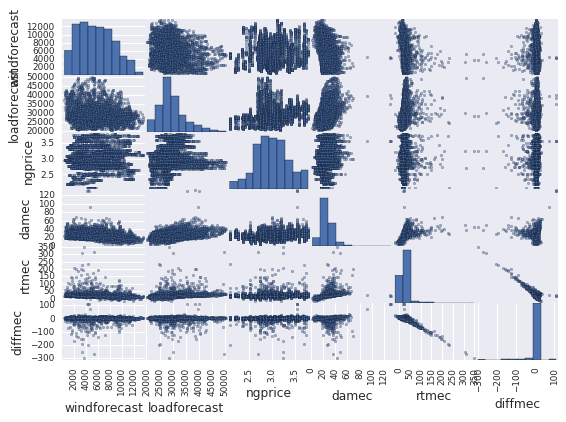

In [9]:
tt = data.copy()
tt.drop('date', axis=1,inplace=True)
tt.drop('hour', axis=1,inplace=True)
pd.tools.plotting.scatter_matrix(tt)

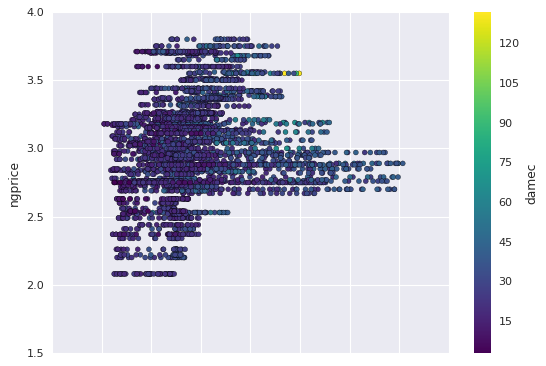

In [26]:
xxs = tt.plot.scatter('loadforecast', 'ngprice', c='damec', colormap='viridis')
#xxs.set_aspect('equal')

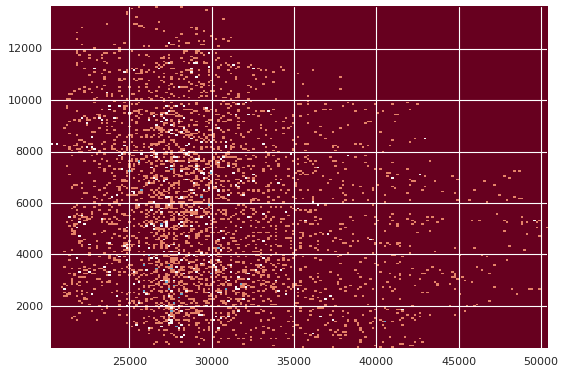

In [20]:
plt.hist2d(tt['loadforecast'],tt['windforecast'], bins=200, cmap=plt.cm.get_cmap('RdBu'))
plt.show()